In [1]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os 
import pandas as pd

INPUT_DIR = 'C:/Users/samee/OneDrive/Desktop/AI-python'

pokemon = pd.read_csv(os.path.join(INPUT_DIR, 'pokemon.csv'))
pokemon = pokemon.sort_values(by='Name')

display(pokemon.head())
display(pokemon.describe())
display(pokemon['Type1'].unique())

,Name,Type1,Type2
459,abomasnow,Grass,Ice
62,abra,Psychic,NaN
358,absol,Dark,NaN
616,accelgor,Bug,NaN
680,aegislash-blade,Steel,Ghost


,Name,Type1,Type2
count,809,809,405
unique,809,18,18
top,abomasnow,Water,Flying
freq,1,114,95


array(['Grass', 'Psychic', 'Dark', 'Bug', 'Steel', 'Rock', 'Normal',
       'Water', 'Dragon', 'Electric', 'Poison', 'Fire', 'Fairy', 'Ice',
       'Ground', 'Ghost', 'Fighting', 'Flying'], dtype=object)

In [3]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
pip install keras-utils

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: keras-utils in c:\python311\lib\site-packages (1.0.13)




[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
from PIL import Image
import numpy as np
from tensorflow.keras.utils import img_to_array

def read_img(imgname):
    img = Image.open(imgname)
    img = img.convert('RGBA')

    basename = os.path.basename(imgname)
    name, suffix = basename.split('.')

    if suffix == 'png':
        white_bg = Image.new('RGBA', img.size, (255,255,255))
        img = Image.alpha_composite(white_bg, img)

    mdata = img_to_array(img, dtype='float32')
    mdata = 1.0 - mdata.astype(np.float32)/255

    return mdata[:, :, :3], name

In [7]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()

type1 = encoder.fit_transform(pokemon['Type1'].values)
display(type1)
encoder.classes_

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

array(['Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire',
       'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'Normal', 'Poison',
       'Psychic', 'Rock', 'Steel', 'Water'], dtype='<U8')

In [10]:
def get_type1name(name):
    return pokemon[pokemon['Name'] == name]['Type1'].values[0]


def encode_type(type_name):
    return encoder.transform(type_name)

def decode_type(type1):
    return encoder.inverse_transform(type1)

In [11]:
print('Type1 of pokemon abomasnow:', get_type1name('abomasnow'))

typelabel1 = encode_type(['Grass'])
print('Type1 encoding of Grass:', typelabel1)

print('Reverse decode of type:', decode_type(typelabel1))

Type1 of pokemon abomasnow: Grass
Type1 encoding of Grass: [[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]]
Reverse decode of type: ['Grass']


In [12]:
import os

def gen_train_imgs():
    imglist = os.listdir(os.path.join(INPUT_DIR, 'images/images'))

    for i, img in enumerate(imglist):
        imgdata, name = read_img(os.path.join(INPUT_DIR, 'images/images', img))
        pokemon_type = get_type1name(name)

        type_label = encode_type([pokemon_type])[0]
        yield (imgdata, type_label)

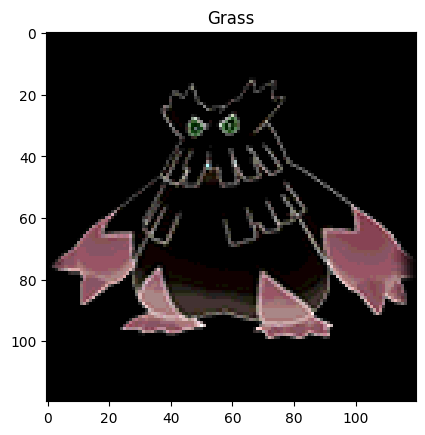

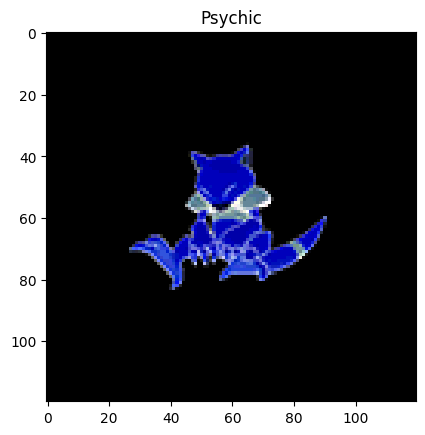

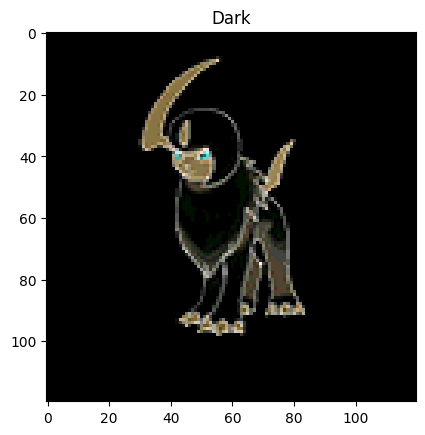

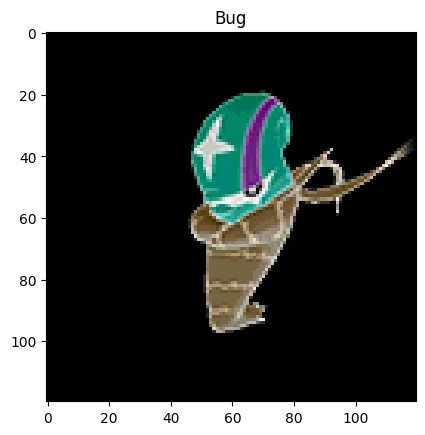

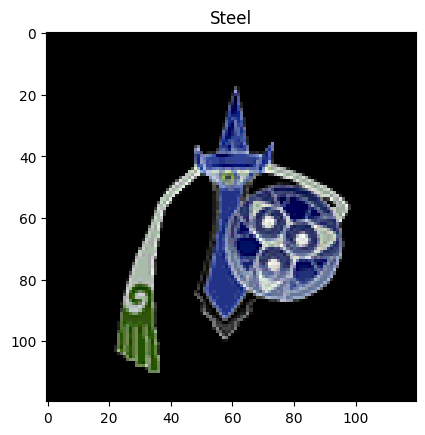

In [13]:
import matplotlib.pyplot as plt

g = gen_train_imgs()

for i in range(5):
    mdata, label = next(g)

    labelname = decode_type(np.array([label]))
    plt.title(labelname[0])
    plt.imshow(mdata)
    plt.show()

In [14]:
import tensorflow as tf

dataset = tf.data.Dataset.from_generator(
    gen_train_imgs,
    output_signature=(
        tf.TensorSpec(shape=(120,120,3), dtype=tf.float32),
        tf.TensorSpec(shape=(18,), dtype=tf.int32),
    ),
)

In [15]:
# split the train validation
data_size = pokemon.shape[0]

train_size = int(data_size * 0.8)
val_size = data_size - train_size

print(f'Splitting data size of {data_size} to train: {train_size} and val: {val_size}')
dataset = dataset.shuffle(32)

train_data = dataset.take(train_size).batch(8)
val_data = dataset.skip(train_size).take(val_size).batch(8)

Splitting data size of 809 to train: 647 and val: 162


In [18]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras import regularizers

from tensorflow.keras.optimizers import Adam

def build_model():
    model = tf.keras.Sequential([
        Conv2D(32, 3, 3, input_shape=(120, 120, 3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),
        Conv2D(16, 3, 3, padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(18, activation='softmax'),
    ])
    model.compile(optimizer=Adam(lr=0.005),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 40, 40, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 20, 20, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 20, 20, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 16)          4624      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 3, 3, 16)         0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 3, 3, 16)         

In [17]:
history = model.fit(
    train_data,
    epochs=20,
    validation_data=val_data,
)

Epoch 1/20
81/81 [==============================] - 14s 151ms/step - loss: 2.8466 - accuracy: 0.1144 - val_loss: 2.7678 - val_accuracy: 0.1235
Epoch 2/20
81/81 [==============================] - 3s 40ms/step - loss: 2.8069 - accuracy: 0.1159 - val_loss: 2.7042 - val_accuracy: 0.1235
Epoch 3/20
81/81 [==============================] - 4s 45ms/step - loss: 2.7476 - accuracy: 0.1391 - val_loss: 2.6783 - val_accuracy: 0.1358
Epoch 4/20
81/81 [==============================] - 4s 54ms/step - loss: 2.7133 - accuracy: 0.1422 - val_loss: 2.6341 - val_accuracy: 0.1481
Epoch 5/20
81/81 [==============================] - 4s 46ms/step - loss: 2.7065 - accuracy: 0.1422 - val_loss: 2.6120 - val_accuracy: 0.1852
Epoch 6/20
81/81 [==============================] - 4s 52ms/step - loss: 2.6720 - accuracy: 0.1808 - val_loss: 2.6026 - val_accuracy: 0.1420
Epoch 7/20
81/81 [==============================] - 3s 39ms/step - loss: 2.6248 - accuracy: 0.1870 - val_loss: 2.5827 - val_accuracy: 0.1667
Epoch 8/20


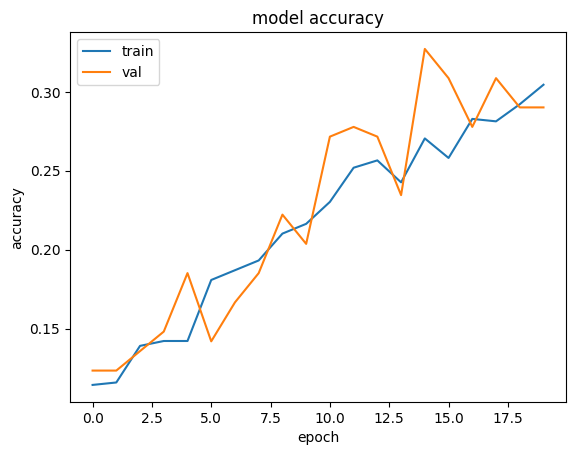

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()